# khởi tạo

In [20]:
from pyspark.sql import SparkSession

# Tạo SparkSession
spark = SparkSession.builder \
    .appName("SFr_weather") \
    .getOrCreate()


# nhập dữ liệu

In [21]:
from pyspark.sql.types import StringType
from pyspark.ml.feature import StandardScaler
# Đọc tệp CSV

df = spark.read.csv("khuyen-nghi.csv", header=True, inferSchema=True)
data = spark.read.csv("Weather-condition.WeatherData.csv", header=True, inferSchema=True)
# Hiển thị 5 dòng đầu tiên
df.show(5)
data.show(5)


+-----------+---------+----+-----------+-----------+-----------+-----------+-------------+--------------+--------------+--------------+-------+---------+-----+-----------+-----------+-----------+-----------+-------+
|      label|Soilcolor|  Ph|     QV2M-W|    QV2M-Sp|    QV2M-Su|    QV2M-Au|PRECTOTCORR-W|PRECTOTCORR-Sp|PRECTOTCORR-Su|PRECTOTCORR-Au|GWETTOP|CLOUD_AMT|   PS|  T2M_AVG-W| T2M_AVG-Sp| T2M_AVG-Su| T2M_AVG-Au|Ph_diff|
+-----------+---------+----+-----------+-----------+-----------+-----------+-------------+--------------+--------------+--------------+-------+---------+-----+-----------+-----------+-----------+-----------+-------+
|Cây Dagussa|     Khác| 5.3|8.566666667|9.663333333|12.73666667|      11.78|  13.43333333|          56.6|         199.2|          74.2|    0.8|    59.11|78.58|     16.255|20.20333334|17.41166667|15.97333334|    1.7|
|Cây Dagussa|      Nâu| 6.3|       8.91|       9.48|12.24666667|11.10666667|  22.93333333|          46.1|   174.4666667|   58.03333333| 

In [22]:
# Hiển thị schema (cấu trúc dữ liệu)
df.printSchema()
data.printSchema()

root
 |-- label: string (nullable = true)
 |-- Soilcolor: string (nullable = true)
 |-- Ph: double (nullable = true)
 |-- QV2M-W: double (nullable = true)
 |-- QV2M-Sp: double (nullable = true)
 |-- QV2M-Su: double (nullable = true)
 |-- QV2M-Au: double (nullable = true)
 |-- PRECTOTCORR-W: double (nullable = true)
 |-- PRECTOTCORR-Sp: double (nullable = true)
 |-- PRECTOTCORR-Su: double (nullable = true)
 |-- PRECTOTCORR-Au: double (nullable = true)
 |-- GWETTOP: double (nullable = true)
 |-- CLOUD_AMT: double (nullable = true)
 |-- PS: double (nullable = true)
 |-- T2M_AVG-W: double (nullable = true)
 |-- T2M_AVG-Sp: double (nullable = true)
 |-- T2M_AVG-Su: double (nullable = true)
 |-- T2M_AVG-Au: double (nullable = true)
 |-- Ph_diff: double (nullable = true)

root
 |-- _id: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- humidity_air: integer (nullable = true)
 |-- pressure: integer (nullable = true)
 |-- soil_moisture: double (nullable = true)
 |-- times

In [23]:

from pyspark.ml.feature import VectorAssembler, StringIndexer

# Chuyển đổi label sang số (nếu là chuỗi)
label_indexer = StringIndexer(inputCol="label", outputCol="indexed_label")
df = label_indexer.fit(df).transform(df)

soilcolor_indexer = StringIndexer(inputCol="soilcolor", outputCol="indexed_soilcolor")

df.show(25)
df1 = df.select("*")

+-----------+---------------+----+-----------+-----------+-----------+-----------+-------------+--------------+--------------+--------------+-------+---------+-----+-----------+-----------+-----------+-----------+-------+-------------+
|      label|      Soilcolor|  Ph|     QV2M-W|    QV2M-Sp|    QV2M-Su|    QV2M-Au|PRECTOTCORR-W|PRECTOTCORR-Sp|PRECTOTCORR-Su|PRECTOTCORR-Au|GWETTOP|CLOUD_AMT|   PS|  T2M_AVG-W| T2M_AVG-Sp| T2M_AVG-Su| T2M_AVG-Au|Ph_diff|indexed_label|
+-----------+---------------+----+-----------+-----------+-----------+-----------+-------------+--------------+--------------+--------------+-------+---------+-----+-----------+-----------+-----------+-----------+-------+-------------+
|Cây Dagussa|           Khác| 5.3|8.566666667|9.663333333|12.73666667|      11.78|  13.43333333|          56.6|         199.2|          74.2|    0.8|    59.11|78.58|     16.255|20.20333334|17.41166667|15.97333334|    1.7|         10.0|
|Cây Dagussa|            Nâu| 6.3|       8.91|       9.4

# đánh giá mức độ tương quan

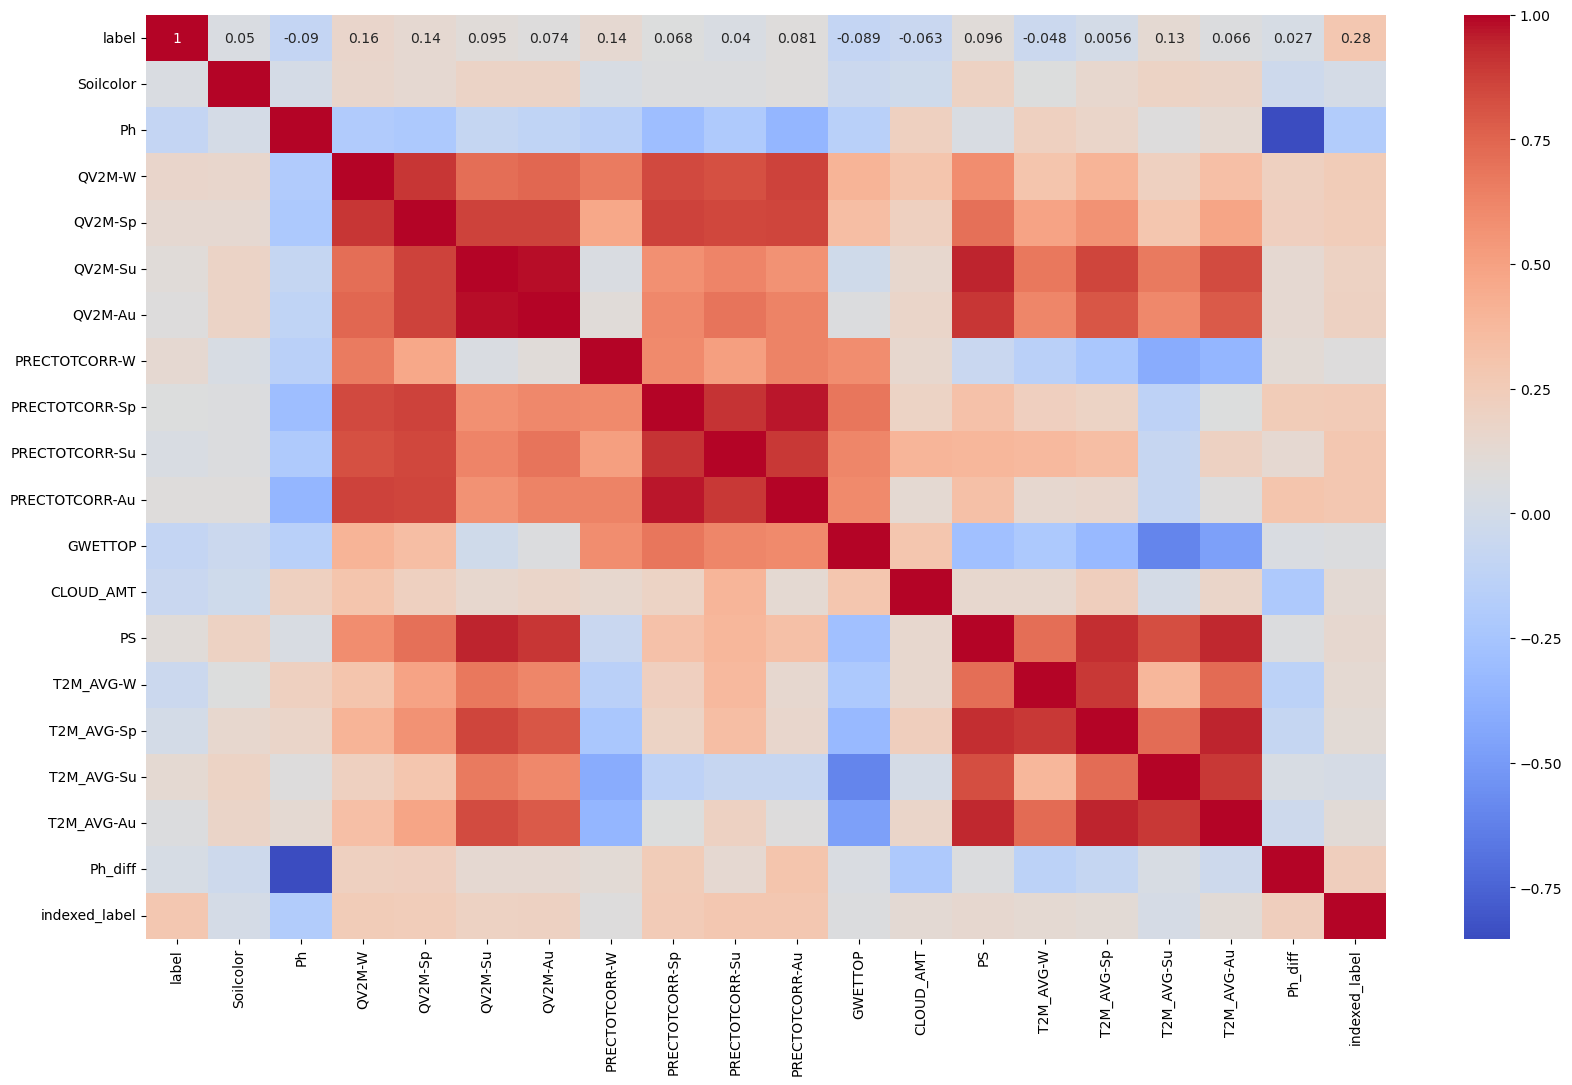

In [24]:
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
df_pandas = df.toPandas()
# Convert categorical columns 'label' and 'Soilcolor' to numerical values
df_pandas['label'] = df_pandas['label'].astype('category').cat.codes
df_pandas['Soilcolor'] = df_pandas['Soilcolor'].astype('category').cat.codes
# Plot heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(df_pandas.corr(), annot=True, cmap='coolwarm')
plt.show()

# chuyển các dữ liệu thời gian thực sang các dữ liệu phù hợp với mô hình

In [25]:
from pyspark.sql.functions import col

# Thêm cột mới "temperature_c"
data = data.withColumn("T2M_AVG-Sp", (col("temperature")))
# Suy ra các giá trị T2M khác từ df và lưu vào cột tương ứng ở data
for season in ["W","Sp", "Su", "Au"]:
    data = data.withColumn(f"T2M_AVG-{season}", col("temperature") + (df.select(f"T2M_AVG-{season}").first()[0] - df.select("T2M_AVG-Sp").first()[0]))
# Hiển thị dữ liệu
data.show()


+--------------------+-----------+------------+--------+-------------+--------------------+----------+------------------+-----------------+-----------------+
|                 _id|temperature|humidity_air|pressure|soil_moisture|           timestamp|T2M_AVG-Sp|         T2M_AVG-W|       T2M_AVG-Su|       T2M_AVG-Au|
+--------------------+-----------+------------+--------+-------------+--------------------+----------+------------------+-----------------+-----------------+
|679058dd87d8dc682...|      11.75|          51|    1031|        0.061|2025-01-22 02:32:...|     11.75| 7.801666659999999|8.958333329999999|             7.52|
|67905fe287d8dc682...|      11.41|          54|    1031|        0.061|2025-01-22 03:02:...|     11.41| 7.461666659999999|8.618333329999999|             7.18|
|679066ec87d8dc682...|      11.19|          55|    1031|        0.061|2025-01-22 03:33:...|     11.19| 7.241666659999998|8.398333329999998|6.959999999999999|
|67906df687d8dc682...|      10.99|          57|    1

In [26]:
data = data.drop("temperature","timestamp","_id")
data.show()

+------------+--------+-------------+----------+------------------+-----------------+-----------------+
|humidity_air|pressure|soil_moisture|T2M_AVG-Sp|         T2M_AVG-W|       T2M_AVG-Su|       T2M_AVG-Au|
+------------+--------+-------------+----------+------------------+-----------------+-----------------+
|          51|    1031|        0.061|     11.75| 7.801666659999999|8.958333329999999|             7.52|
|          54|    1031|        0.061|     11.41| 7.461666659999999|8.618333329999999|             7.18|
|          55|    1031|        0.061|     11.19| 7.241666659999998|8.398333329999998|6.959999999999999|
|          57|    1031|        0.061|     10.99| 7.041666659999999|8.198333329999999|             6.76|
|          58|    1031|        0.061|     10.76| 6.811666659999998|7.968333329999998|6.529999999999999|
|          58|    1031|        0.042|     10.84|6.8916666599999985|8.048333329999998|6.609999999999999|
|          60|    1031|        0.042|     10.32| 6.3716666599999

In [27]:
data = data.withColumnRenamed("pressure", "PS").withColumn("PS", col("PS") / 10)
data.show()

+------------+-----+-------------+----------+------------------+-----------------+-----------------+
|humidity_air|   PS|soil_moisture|T2M_AVG-Sp|         T2M_AVG-W|       T2M_AVG-Su|       T2M_AVG-Au|
+------------+-----+-------------+----------+------------------+-----------------+-----------------+
|          51|103.1|        0.061|     11.75| 7.801666659999999|8.958333329999999|             7.52|
|          54|103.1|        0.061|     11.41| 7.461666659999999|8.618333329999999|             7.18|
|          55|103.1|        0.061|     11.19| 7.241666659999998|8.398333329999998|6.959999999999999|
|          57|103.1|        0.061|     10.99| 7.041666659999999|8.198333329999999|             6.76|
|          58|103.1|        0.061|     10.76| 6.811666659999998|7.968333329999998|6.529999999999999|
|          58|103.1|        0.042|     10.84|6.8916666599999985|8.048333329999998|6.609999999999999|
|          60|103.1|        0.042|     10.32| 6.371666659999999|7.528333329999999|         

In [28]:
data = data.withColumnRenamed("humidity_air", "QV2M-Sp").withColumn("QV2M-Sp", col("QV2M-Sp") / 10)
data.show()

+-------+-----+-------------+----------+------------------+-----------------+-----------------+
|QV2M-Sp|   PS|soil_moisture|T2M_AVG-Sp|         T2M_AVG-W|       T2M_AVG-Su|       T2M_AVG-Au|
+-------+-----+-------------+----------+------------------+-----------------+-----------------+
|    5.1|103.1|        0.061|     11.75| 7.801666659999999|8.958333329999999|             7.52|
|    5.4|103.1|        0.061|     11.41| 7.461666659999999|8.618333329999999|             7.18|
|    5.5|103.1|        0.061|     11.19| 7.241666659999998|8.398333329999998|6.959999999999999|
|    5.7|103.1|        0.061|     10.99| 7.041666659999999|8.198333329999999|             6.76|
|    5.8|103.1|        0.061|     10.76| 6.811666659999998|7.968333329999998|6.529999999999999|
|    5.8|103.1|        0.042|     10.84|6.8916666599999985|8.048333329999998|6.609999999999999|
|    6.0|103.1|        0.042|     10.32| 6.371666659999999|7.528333329999999|             6.09|
|    6.0|103.1|        0.042|     10.21|

In [29]:

# Suy ra các giá trị T2M khác từ df và lưu vào cột tương ứng ở data
for season in ["W","Sp", "Su", "Au"]:
    data = data.withColumn(f"QV2M-{season}", col("QV2M-Sp") + (df.select(f"QV2M-{season}").first()[0] - df.select("QV2M-Sp").first()[0]))
# Hiển thị dữ liệu
data.show()

+-------+-----+-------------+----------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|QV2M-Sp|   PS|soil_moisture|T2M_AVG-Sp|         T2M_AVG-W|       T2M_AVG-Su|       T2M_AVG-Au|            QV2M-W|           QV2M-Su|           QV2M-Au|
+-------+-----+-------------+----------+------------------+-----------------+-----------------+------------------+------------------+------------------+
|    5.1|103.1|        0.061|     11.75| 7.801666659999999|8.958333329999999|             7.52| 4.003333333999999| 8.173333336999999| 7.216666666999998|
|    5.4|103.1|        0.061|     11.41| 7.461666659999999|8.618333329999999|             7.18|4.3033333339999995|       8.473333337| 7.516666666999999|
|    5.5|103.1|        0.061|     11.19| 7.241666659999998|8.398333329999998|6.959999999999999| 4.403333333999999|       8.573333337| 7.616666666999999|
|    5.7|103.1|        0.061|     10.99| 7.041666659999999|8.198333329999999|     

In [30]:
data = data.withColumnRenamed("soil_moisture", "GWETTOP")
data = data.select(*sorted(data.columns))
data.show()

+-------+-----+------------------+-------+------------------+------------------+-----------------+----------+-----------------+------------------+
|GWETTOP|   PS|           QV2M-Au|QV2M-Sp|           QV2M-Su|            QV2M-W|       T2M_AVG-Au|T2M_AVG-Sp|       T2M_AVG-Su|         T2M_AVG-W|
+-------+-----+------------------+-------+------------------+------------------+-----------------+----------+-----------------+------------------+
|  0.061|103.1| 7.216666666999998|    5.1| 8.173333336999999| 4.003333333999999|             7.52|     11.75|8.958333329999999| 7.801666659999999|
|  0.061|103.1| 7.516666666999999|    5.4|       8.473333337|4.3033333339999995|             7.18|     11.41|8.618333329999999| 7.461666659999999|
|  0.061|103.1| 7.616666666999999|    5.5|       8.573333337| 4.403333333999999|6.959999999999999|     11.19|8.398333329999998| 7.241666659999998|
|  0.061|103.1| 7.816666666999999|    5.7|       8.773333337| 4.603333333999999|             6.76|     10.99|8.1983333

# huấn luyện 1 mô hình mẫu 

In [31]:
# Lưu vào biến feature_columns
feature_columns = data.columns

# Xóa cột 'label' khỏi feature_columns
print(feature_columns)

['GWETTOP', 'PS', 'QV2M-Au', 'QV2M-Sp', 'QV2M-Su', 'QV2M-W', 'T2M_AVG-Au', 'T2M_AVG-Sp', 'T2M_AVG-Su', 'T2M_AVG-W']


In [32]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df = assembler.transform(df)

scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=False)
df = scaler.fit(df).transform(df)

# Chỉ giữ lại các cột cần thiết
df = df.select("features", "indexed_label").withColumnRenamed("indexed_label", "label")


In [33]:
# Chia dữ liệu thành train (80%) và test (20%)
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Kiểm tra kích thước của mỗi tập
print("Train size:", train_df.count())
print("Test size:", test_df.count())

Train size: 82
Test size: 17


In [35]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=50)
rf_model = rf.fit(train_df)
predictions = rf_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(predictions)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 0.18


In [36]:
# Chuyển đổi dữ liệu từ data thành định dạng phù hợp với mô hình
data_assembled = assembler.transform(data)

# Áp dụng StandardScaler để chuẩn hóa dữ liệu
scaler_model = scaler.fit(data_assembled)
data_scaled = scaler_model.transform(data_assembled)

# Chỉ giữ lại các cột cần thiết
data_prepared = data_scaled.select("features")

# Sử dụng mô hình đã huấn luyện để dự đoán trên dữ liệu mới
data_predictions = rf_model.transform(data_prepared)

# Hiển thị kết quả dự đoán
data_predictions.show()

+--------------------+--------------------+--------------------+----------+
|            features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|[0.061,103.1,7.21...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.061,103.1,7.51...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.061,103.1,7.61...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.061,103.1,7.81...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.061,103.1,7.91...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.042,103.1,7.91...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.042,103.1,8.11...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.042,103.1,8.11...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.042,103.1,8.21...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.042,103.0,8.31...|[1.65708180708180...|[0.03314163614163...|       2.0|
|[0.042,103.

In [39]:
from pyspark.sql.functions import col
from pyspark.sql.functions import col

# Thực hiện join giữa df1 và data_predictions dựa trên điều kiện indexed_label == prediction
result = df1.join(data_predictions, df1["indexed_label"] == data_predictions["prediction"])

# Hiển thị kết quả
result.show()
# vậy cột label là cột dự đoán của mô hình

# Xuất kết quả ra file CSV
result.toPandas().to_csv("result.csv", index=False)

+--------+---------+---+-----------+-----------+-------+-------+-------------+--------------+--------------+--------------+-------+---------+-----+---------+-----------+-----------+----------+-------+-------------+--------------------+--------------------+--------------------+----------+
|   label|Soilcolor| Ph|     QV2M-W|    QV2M-Sp|QV2M-Su|QV2M-Au|PRECTOTCORR-W|PRECTOTCORR-Sp|PRECTOTCORR-Su|PRECTOTCORR-Au|GWETTOP|CLOUD_AMT|   PS|T2M_AVG-W| T2M_AVG-Sp| T2M_AVG-Su|T2M_AVG-Au|Ph_diff|indexed_label|            features|       rawPrediction|         probability|prediction|
+--------+---------+---+-----------+-----------+-------+-------+-------------+--------------+--------------+--------------+-------+---------+-----+---------+-----------+-----------+----------+-------+-------------+--------------------+--------------------+--------------------+----------+
|Lúa mạch|     Khác|7.1|7.586666667|8.136666667|  11.43|  10.15|          9.1|   22.66666667|   117.6666667|          29.6|   0.63|  